In [1]:
import sys
sys.path.append('..')
import tulipy as tp
import pandas as pd
import numpy as np
from peakdetect import peakdetect
from utilities.functions import do_db_connection
from utilities.talib_related import db_historical_to_df
from utilities.config import DB_PATH
import yfinance as yf
import random

connection = do_db_connection(DB_PATH)
cursor = connection.cursor()
symbols = cursor.execute('select distinct Symbol from historical_data').fetchall()
symbols = [symbol['Symbol'] for symbol in symbols]
for symbol in symbols:
    if symbol == 'AAPL':
        


        df = db_historical_to_df(symbol, cursor)
        df.dropna(inplace=True)
        stoch_rsi = tp.stochrsi(df['Close'].values, period=5)
        ultosc = tp.ultosc(df['High'].values, df['Low'].values, df['Close'].values, 3, 3 * 2, 3 * 4)
        aroonsc = tp.aroonosc(df['High'].values, df['Low'].values, period=3)

        df = df[::-1]
        df['STOCH_RSI'] = pd.Series(stoch_rsi[::-1], index=df.index[:len(stoch_rsi)])
        # df['Aroon'] = pd.Series(aroonsc[::-1], index=df.index[:len(aroonsc)])
        df['ULTOSC'] = pd.Series(ultosc[::-1], index=df.index[:len(ultosc)])
        df = df[::-1]

        df = df.drop(['Open', 'Volume', 'High', 'Low'], axis=1)
        df.dropna(inplace=True)

        max_peaks, min_peaks = peakdetect(df['Close'].values, lookahead=5) 
        min_peaks = [i for i, _ in min_peaks]
        max_peaks = [i for i, _ in max_peaks]

        df['Buy'] =[1 if i in min_peaks else 0 for i, _ in enumerate(df.index)]
        while not df['Buy'].value_counts()[1] == df['Buy'].value_counts()[0]:
            random_number = random.randint(0, len(df) - 1)
            if df.iloc[random_number]['Buy'] == 0:
                df = df.drop(df.index[random_number])


<AxesSubplot:xlabel='STOCH_RSI', ylabel='ULTOSC'>

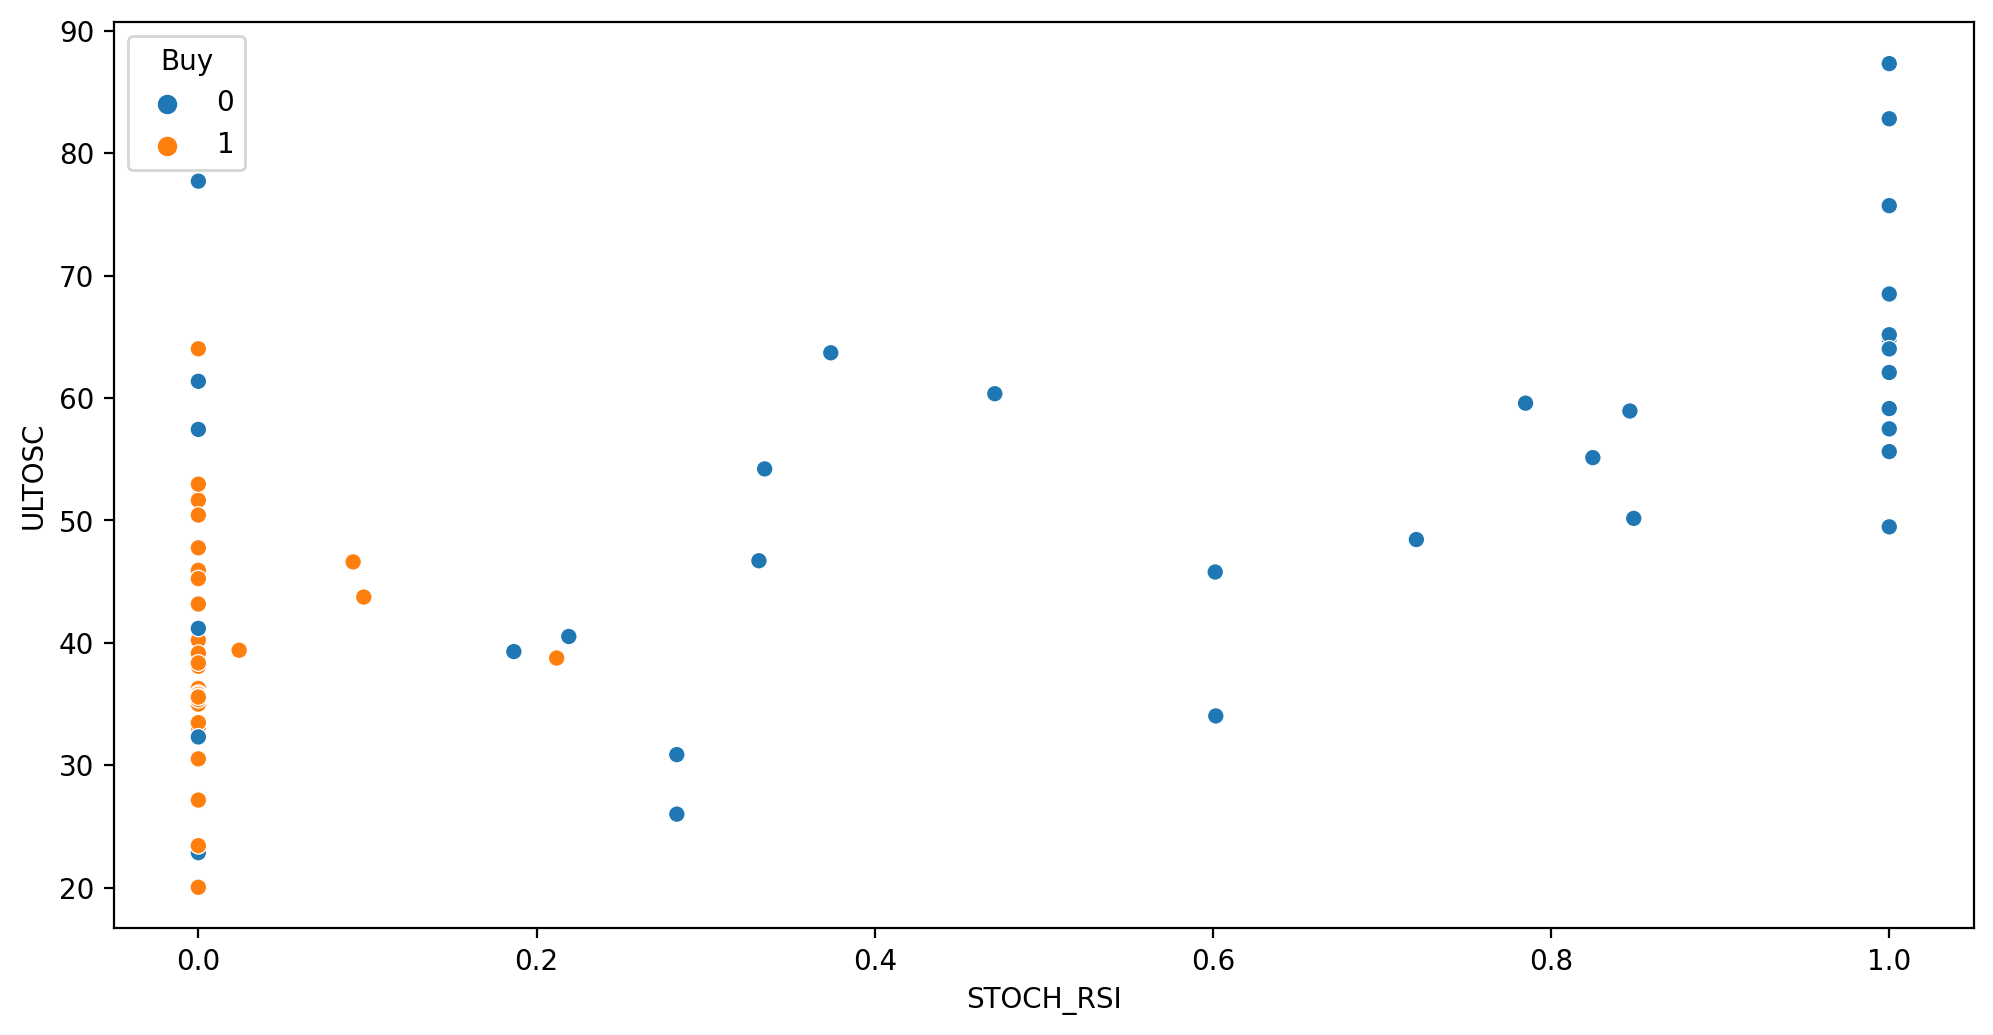

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), dpi=200)
sns.scatterplot(data=df, x='STOCH_RSI', y='ULTOSC', hue='Buy', palette='tab10')

<Figure size 2400x1200 with 0 Axes>

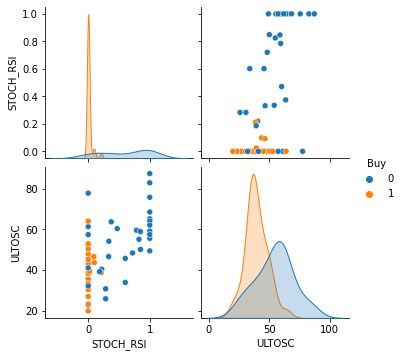

In [3]:
plt.figure(figsize=(12,6), dpi=200)
sns.pairplot(data=df.drop('Close', axis=1), hue='Buy', palette='tab10');

<AxesSubplot:>

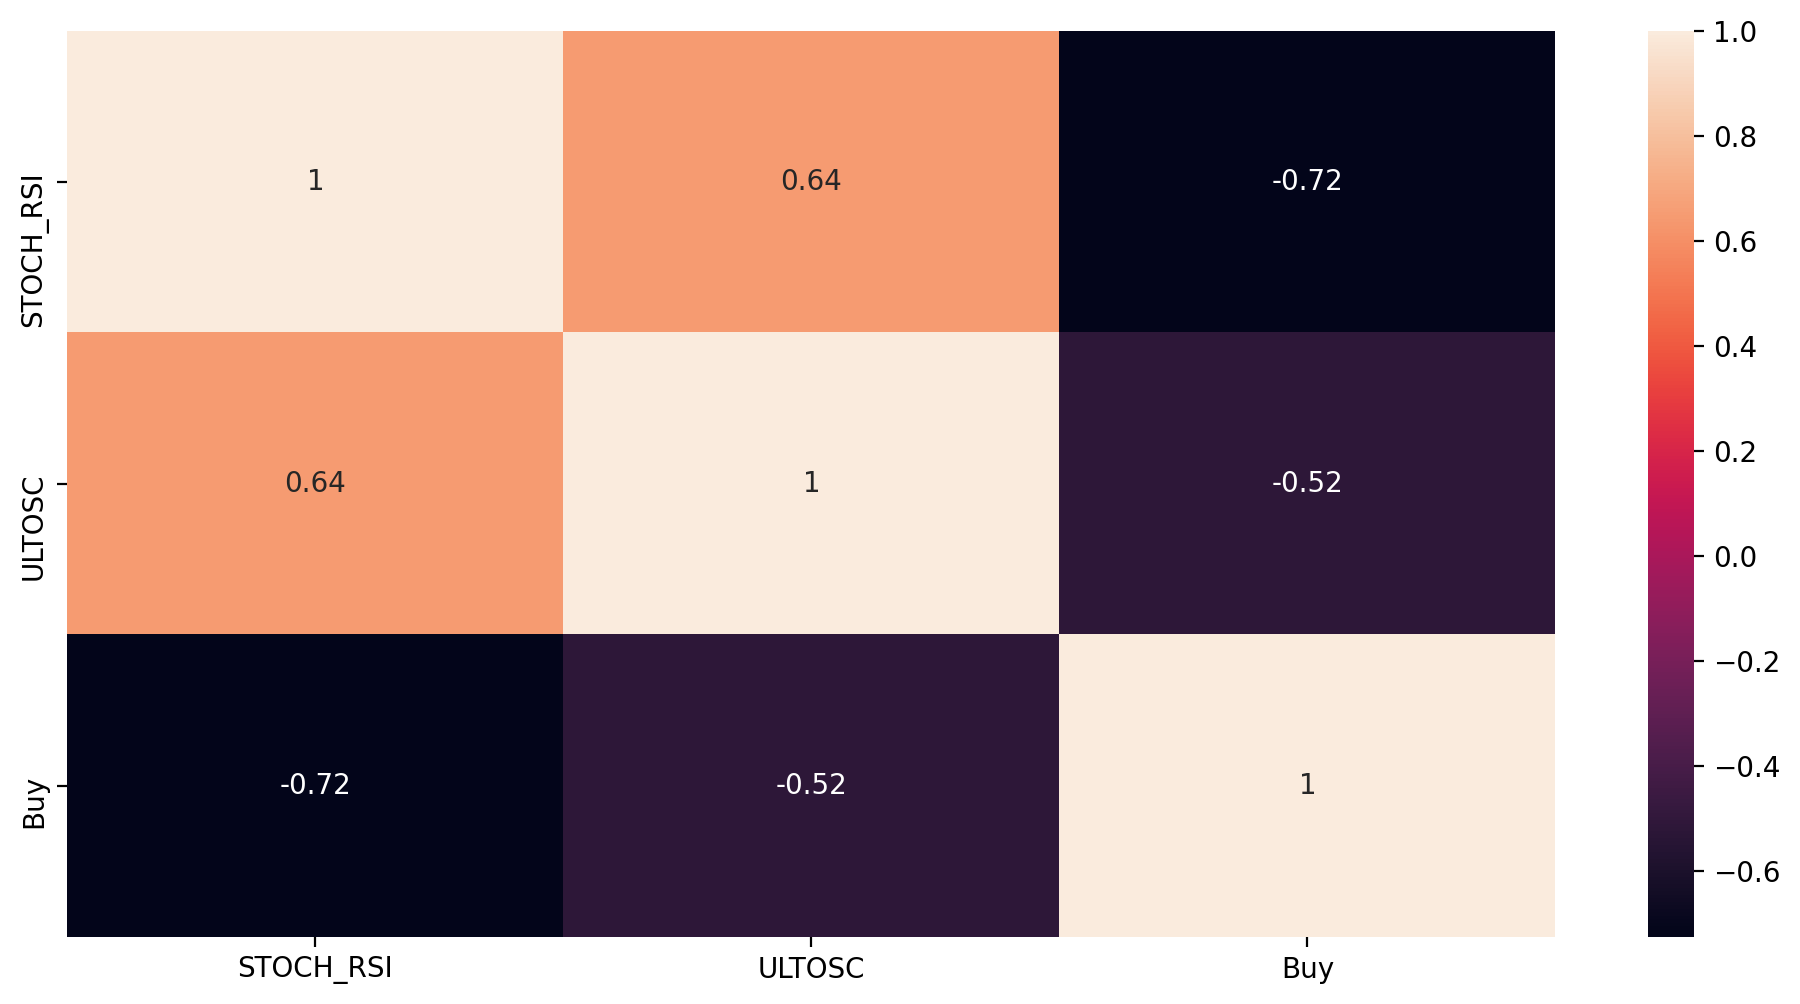

In [4]:
plt.figure(figsize=(12,6), dpi=200)
sns.heatmap(df.drop('Close', axis=1).corr(),annot=True)

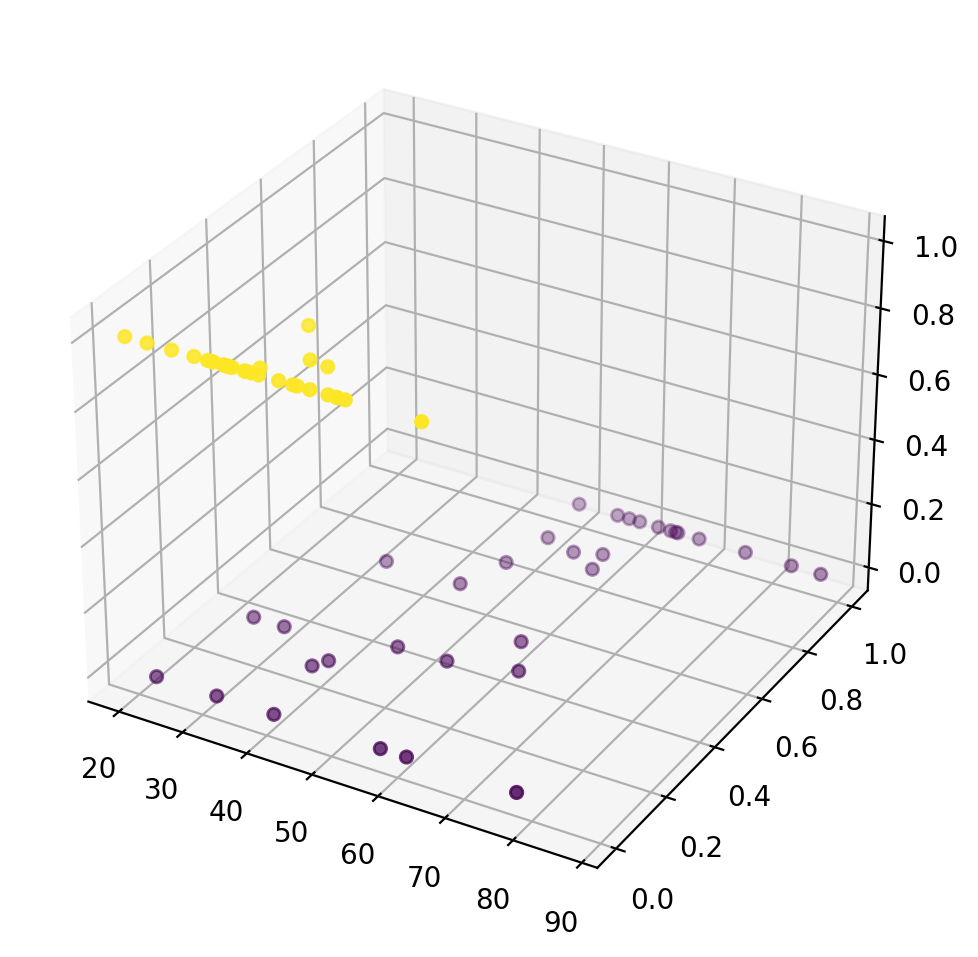

In [5]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(12,6),dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['ULTOSC'],df['STOCH_RSI'],df['Buy'],c=df['Buy'])

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(['Close', 'Buy'], axis=1)
y = df['Buy']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(scaled_X_train, y_train)
y_hat = knn_model.predict(scaled_X_test)

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
confusion_matrix(y_test, y_hat)

array([[7, 2],
       [1, 7]])

In [12]:
print(classification_report(y_test, y_hat))
len(df)

              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.78      0.88      0.82         8

    accuracy                           0.82        17
   macro avg       0.83      0.83      0.82        17
weighted avg       0.83      0.82      0.82        17



66

In [13]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
test_error_rates = []

for k in range(1, 50):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train, y_train)

    y_pred_test = knn_model.predict(scaled_X_test)

    test_error = 1 - accuracy_score(y_test, y_pred_test)
    test_error_rates.append(test_error)

In [14]:
test_error_rates

[0.17647058823529416,
 0.17647058823529416,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.11764705882352944,
 0.17647058823529416,
 0.11764705882352944,
 0.17647058823529416,
 0.17647058823529416,
 0.17647058823529416,
 0.17647058823529416,
 0.17647058823529416,
 0.17647058823529416,
 0.23529411764705888,
 0.23529411764705888,
 0.2941176470588235,
 0.29411764

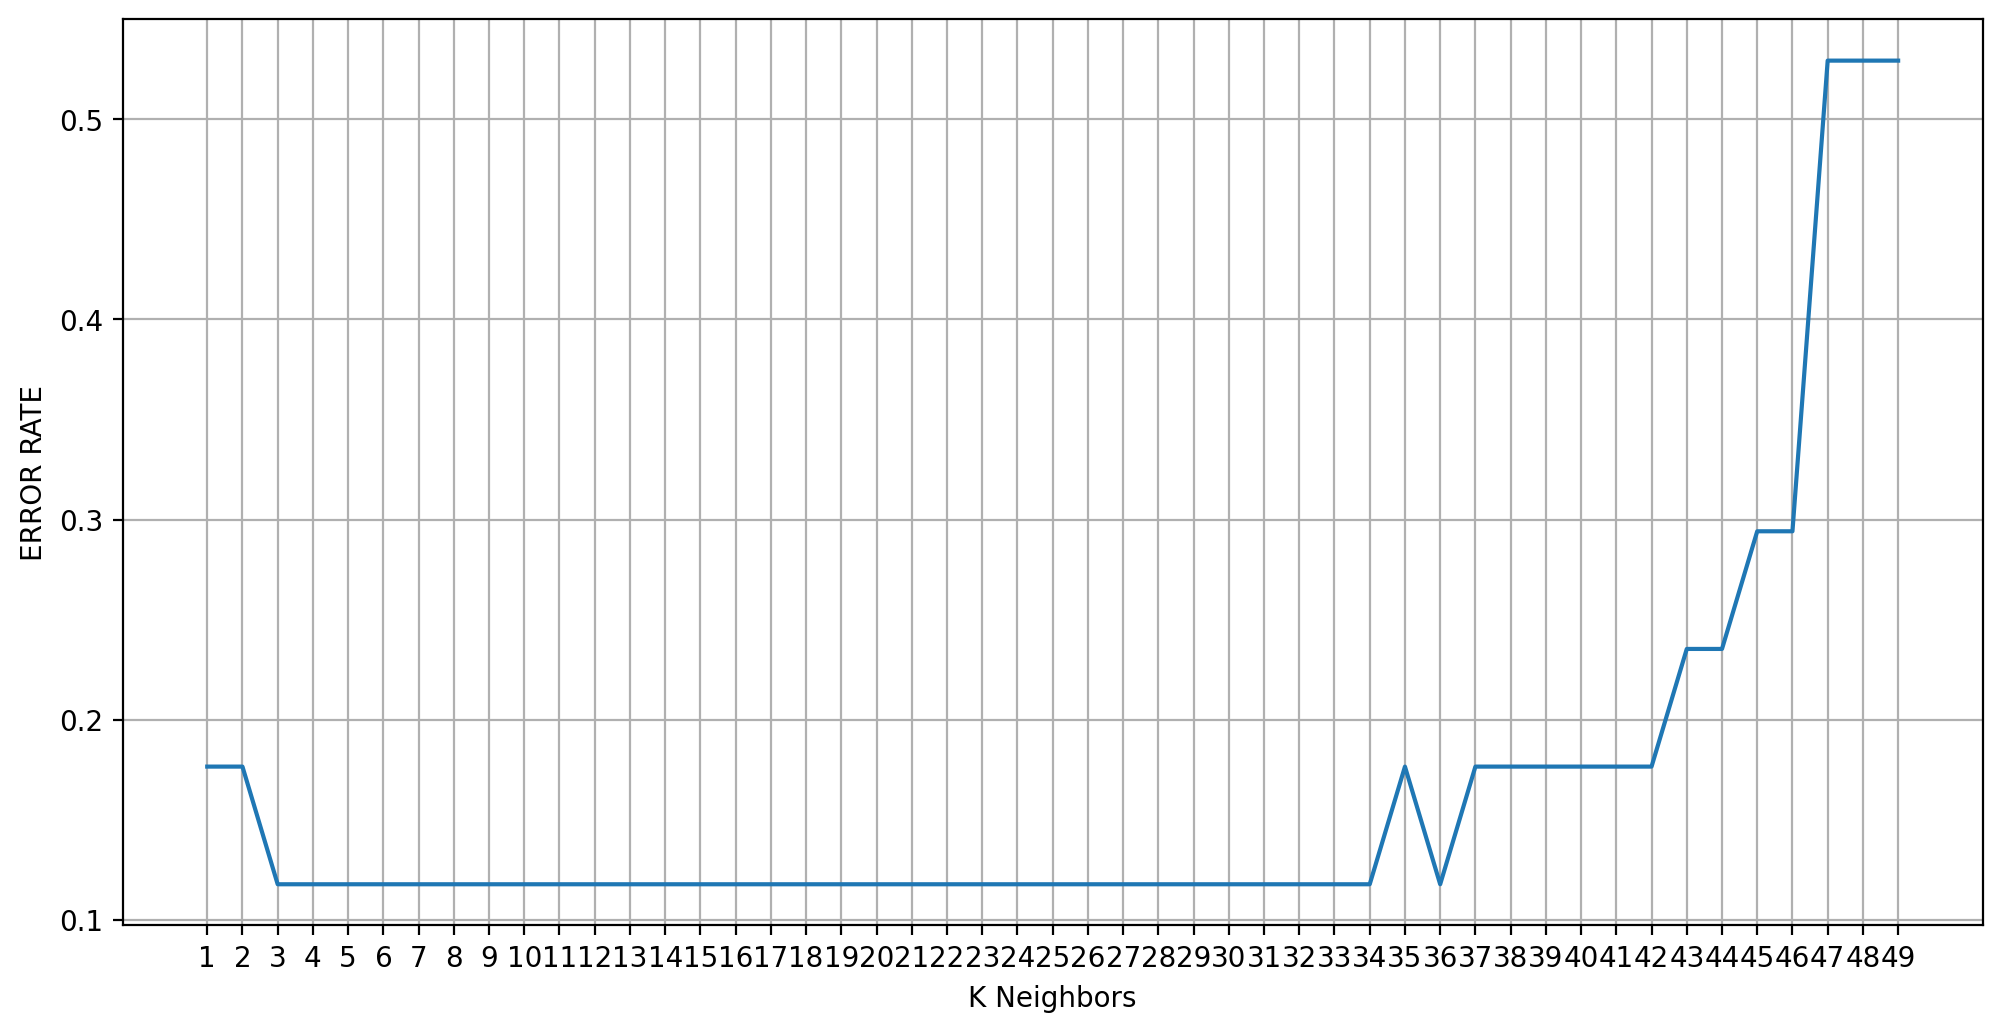

In [15]:
plt.figure(figsize=(12,6), dpi=200)
plt.plot(range(1, 50), test_error_rates)
plt.xticks(range(1, 50))
plt.ylabel('ERROR RATE')
plt.xlabel('K Neighbors')
plt.grid()

In [16]:
scaler = StandardScaler()
knn = KNeighborsClassifier()
knn.get_params().keys()
operations = [('scaler',scaler),('knn',knn)]

In [17]:
from sklearn.pipeline import Pipeline
pipe = Pipeline(operations)

In [18]:
from sklearn.model_selection import GridSearchCV
pipe = Pipeline(operations)

k_values = list(range(1,30))
k_values

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [19]:
param_grid = {'knn__n_neighbors': k_values}

In [20]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')

In [21]:
full_cv_classifier.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

In [22]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=2))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=2),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 2,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [23]:
full_pred = full_cv_classifier.predict(X_test)

In [24]:
print(classification_report(y_test, full_pred))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.78      0.88      0.82         8

    accuracy                           0.82        17
   macro avg       0.83      0.83      0.82        17
weighted avg       0.83      0.82      0.82        17



In [25]:
#Final Model
scaler = StandardScaler()
knn27 = KNeighborsClassifier(n_neighbors=27)
operations = [('scaler',scaler),('knn27',knn27)]
pipe = Pipeline(operations)
pipe.fit(X_train,y_train)
pipe_pred = pipe.predict(X_test)
print(classification_report(y_test,pipe_pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.80      1.00      0.89         8

    accuracy                           0.88        17
   macro avg       0.90      0.89      0.88        17
weighted avg       0.91      0.88      0.88        17



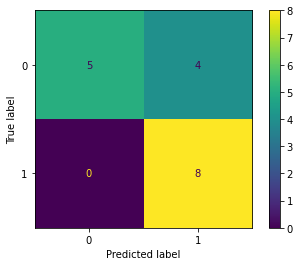

In [26]:
plot_confusion_matrix(pipe, scaled_X_test, y_test)